In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import scipy.stats as stats
import seaborn as sns
import ast

sns.set(style='ticks', color_codes = True)


from pandas.plotting import scatter_matrix
import statsmodels.api as sm
from time import time

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import power_transform
from sklearn import preprocessing

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import log_loss, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV


sns.set(style='ticks', color_codes = True)

In [2]:
def heatMap(df):
    #Create Correlation df
    corr = df.corr()
    #Plot figsize
    fig, ax = plt.subplots(figsize=(20, 20))
    #Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    #Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns)
    #show plot
    plt.show()
# https://theakway.blog/2018/08/10/linear-regression-with-python-sklearn/

def rss(model,X,y):
    '''
    Function to calculate the residual sum of squared of the model
    Input:
        model: Trained linear regression model
        X: Training predictors as a pandas dataframe
        y: Training responses as a pandas dataframe
    Output:
        The RSS of the model
    '''
    res = y - model.predict(X)
    return sum(res**2)
 
def rse(model,X,y):
    '''
    Function to calculate the residual standard error of the model
    Input:
        model: Trained linear regression model
        X: Training predictors as a pandas dataframe
        y: Training responses as a pandas dataframe
    Output:
        The RSE of the model
    '''
    return np.sqrt(rss(model,X,y)/(X.shape[0]-X.shape[1]-1))
 
def studresidplot(model,X,y,threshold=3,ax=None, **kwargs):
    '''
    This function plots a studentized residual plot
    Inputs:
        model = Trained sklearn model
        X: Predictors as a pandas dataframe
        y: Responses as a pandas dataframe
        Threshold: Threshold to identify outliers
        kwargs: seaborn.residplot arguments
    Output:
        Boolean mask for outliers(False if outlier)
    '''
    vals = {'Studentized Residuals': (y-model.predict(X))/rse(model,X,y), 'Predicted Values': model.predict(X)}
    resdf = pd.DataFrame(vals)
    resdf['Outlier'] = resdf['Studentized Residuals'].apply(lambda x: 'Outlier' if abs(x)>= threshold else 'Normal')
    #ax = sns.lmplot(y='Studentized Residuals',x='Predicted Values', hue='Outlier' , data=resdf, fit_reg=False, **kwargs)
    ax = sns.scatterplot(y='Studentized Residuals',x='Predicted Values', hue='Outlier' , data=resdf, ax=ax, **kwargs)
    return resdf['Studentized Residuals'].apply(lambda x: False if abs(x)>= 3 else True)

# Input 

In [3]:
df = pd.read_csv('seatgeek_ticket_info.csv')
df.head()

/Users/linhchau/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (10,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Unnamed: 0 access_method        announce_date  \
0           0           NaN  2019-01-23T00:00:00   
1           1           NaN  2018-12-20T00:00:00   
2           2           NaN  2019-05-02T00:00:00   
3           3           NaN  2019-05-14T00:00:00   
4           4           NaN  2019-08-24T00:00:00   

                                       announcements  conditional  \
0  {'checkout_disclosures': {'messages': [{'text'...        False   
1  {'checkout_disclosures': {'messages': [{'text'...        False   
2                                                 {}        False   
3                                                 {}        False   
4                                                 {}        False   

            created_at  date_tbd       datetime_local  datetime_tbd  \
0  2019-01-23T16:10:16     False  2019-10-08T03:30:00         False   
1  2018-12-20T16:11:07     False  2019-10-08T03:30:00         False   
2  2019-05-02T16:16:35     False  2019-10-08T19:30:00         False   
3  2019-05-14T02:59:07     False  2019-10-08T18:30:00         False   
4  2019-08-24T16:02:30     False  2019-10-08T20:30:00         False   

          datetime_utc  ...                           venue_name_v2  \
0  2019-10-08T10:30:00  ...  Le Theatre Des Arts at Paris Las Vegas   
1  2019-10-08T10:30:00  ...           High Roller Wheel At the LINQ   
2  2019-10-09T01:30:00  ...                        Colonial Theater   
3  2019-10-09T01:30:00  ...                House of Blues - Anaheim   
4  2019-10-09T01:30:00  ...                               Gasa Gasa   

   venue_num_upcoming_events  venue_popularity venue_postal_code  venue_score  \
0                        161                 0             89109     0.453888   
1                        158                 0             89109     0.000000   
2                          1                 0             83402     0.394669   
3                         52                 0             92802     0.544078   
4                         30                 0             70115     0.354410   

                               venue_slug venue_state       venue_timezone  \
0  le-theatre-des-arts-at-paris-las-vegas          NV  America/Los_Angeles   
1           high-roller-wheel-at-the-linq          NV  America/Los_Angeles   
2                      colonial-theater-2          ID        America/Boise   
3                  house-of-blues-anaheim          CA  America/Los_Angeles   
4                               gasa-gasa          LA      America/Chicago   

                                           venue_url    visible_until_utc  
0  https://seatgeek.com/venues/le-theatre-des-art...  2019-10-09T07:00:00  
1  https://seatgeek.com/venues/high-roller-wheel-...  2019-10-09T07:00:00  
2  https://seatgeek.com/venues/colonial-theater-2...  2019-10-09T05:30:00  
3  https://seatgeek.com/venues/house-of-blues-ana...  2019-10-09T05:30:00  
4      https://seatgeek.com/venues/gasa-gasa/tickets  2019-10-09T05:30:00  

[5 rows x 90 columns]

In [4]:
df.shape

(114368, 90)

In [5]:
df.drop(df.columns[0], axis=1, inplace=True)

In [225]:
df[['stats_average_price',
       'stats_dq_bucket_counts', 'stats_highest_price', 'stats_listing_count',
       'stats_lowest_price', 'stats_lowest_price_good_deals',
       'stats_lowest_sg_base_price', 'stats_lowest_sg_base_price_good_deals',
       'stats_median_price', 'stats_variants', 'stats_visible_listing_count']]

stats_average_price    stats_dq_bucket_counts  stats_highest_price  \
0                      56.0  [0, 0, 0, 0, 0, 0, 0, 0]                 63.0   
1                      65.0  [0, 0, 0, 0, 0, 0, 0, 0]                109.0   
2                     254.0  [0, 0, 0, 0, 0, 0, 0, 0]                293.0   
3                      22.0  [0, 0, 0, 0, 0, 0, 0, 0]                 22.0   
4                      62.0  [0, 0, 0, 0, 0, 0, 0, 0]                 62.0   
5                      56.0  [0, 0, 0, 0, 0, 0, 0, 0]                 67.0   
6                       NaN                       NaN                  NaN   
7                      38.0  [1, 1, 0, 0, 0, 1, 1, 7]                 72.0   
8                       NaN                       NaN                  NaN   
9                       NaN                       NaN                  NaN   
10                      NaN                       NaN                  NaN   
11                     58.0  [0, 0, 0, 0, 0, 0, 0, 0]                 58.0   
12                     95.0  [0, 0, 0, 0, 0, 0, 0, 0]                 95.0   
13                    168.0  [0, 0, 0, 0, 0, 0, 0, 0]                190.0   
14                    129.0  [0, 0, 0, 0, 0, 0, 0, 0]                142.0   
15                      NaN                       NaN                  NaN   
16                      NaN                       NaN                  NaN   
17                    206.0  [0, 0, 0, 0, 0, 0, 0, 0]                241.0   
18                    201.0  [0, 0, 0, 0, 0, 0, 0, 0]                387.0   
19                      NaN                       NaN                  NaN   
20                    103.0  [0, 0, 0, 0, 0, 0, 0, 0]                124.0   
21                    177.0  [0, 0, 0, 0, 0, 0, 0, 0]                214.0   
22                    260.0  [2, 0, 0, 0, 0, 4, 1, 0]                313.0   
23                    115.0  [0, 0, 2, 1, 0, 0, 0, 0]                125.0   
24                    132.0  [0, 0, 1, 1, 0, 0, 0, 0]                168.0   
25                    171.0  [0, 0, 0, 0, 0, 0, 0, 0]                228.0   
26                    141.0  [0, 0, 0, 0, 0, 0, 0, 0]                185.0   
27                     82.0  [0, 0, 0, 0, 0, 0, 0, 0]                 82.0   
28                    189.0  [0, 4, 0, 3, 1, 4, 0, 0]                250.0   
29                    103.0  [0, 0, 0, 0, 0, 0, 0, 0]                103.0   
...                     ...                       ...                  ...   
114338                  NaN                       NaN                  NaN   
114339                  NaN                       NaN                  NaN   
114340                  NaN                       NaN                  NaN   
114341                260.0  [0, 0, 0, 0, 0, 0, 0, 0]                299.0   
114342                198.0  [0, 0, 0, 0, 0, 0, 0, 0]                198.0   
114343                159.0  [0, 0, 0, 0, 0, 0, 0, 0]                176.0   
114344                  NaN                       NaN                  NaN   
114345                  NaN                       NaN                  NaN   
114346                  NaN                       NaN                  NaN   
114347                  NaN                       NaN                  NaN   
114348                  NaN                       NaN                  NaN   
114349                255.0  [0, 0, 0, 0, 0, 0, 0, 0]                294.0   
114350                223.0  [0, 0, 0, 0, 0, 0, 0, 0]                250.0   
114351                157.0  [0, 0, 0, 0, 0, 0, 0, 0]                173.0   
114352                  NaN                       NaN                  NaN   
114353                  NaN                       NaN                  NaN   
114354                  NaN                       NaN                  NaN   
114355                  NaN                       NaN                  NaN   
114356                  NaN                       NaN                  NaN   
114357                  NaN   

In [6]:
df.datetime_local.min()

'2019-10-08T03:30:00'

In [7]:
df.datetime_local.max()

'2029-12-31T18:00:00'

In [8]:
df.info().astype('category')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114368 entries, 0 to 114367
Data columns (total 89 columns):
access_method                            14441 non-null object
announce_date                            114368 non-null object
announcements                            114368 non-null object
conditional                              114368 non-null bool
created_at                               114368 non-null object
date_tbd                                 114368 non-null bool
datetime_local                           114368 non-null object
datetime_tbd                             114368 non-null bool
datetime_utc                             114368 non-null object
description                              18 non-null object
enddatetime_utc                          0 non-null float64
event_promotion                          0 non-null float64
general_admission                        14624 non-null object
id                                       114368 non-null int64
is_open       

AttributeError: 'NoneType' object has no attribute 'astype'

In [9]:
df.venue_metro_code

0         839
1         839
2         758
3         803
4         622
5         751
6         602
7         751
8           0
9         635
10          0
11        669
12          0
13        770
14        839
15        501
16        866
17        807
18        757
19        807
20          0
21        839
22        839
23          0
24        753
25        839
26        839
27        770
28        839
29        790
         ... 
114338    518
114339    518
114340    518
114341    518
114342    518
114343    518
114344    518
114345    518
114346    518
114347    518
114348    518
114349    518
114350    518
114351    518
114352    518
114353    807
114354    546
114355    807
114356    807
114357    807
114358    807
114359    807
114360    807
114361    807
114362    807
114363    807
114364    807
114365    807
114366      0
114367      0
Name: venue_metro_code, Length: 114368, dtype: int64

In [10]:
df.columns

Index(['access_method', 'announce_date', 'announcements', 'conditional',
       'created_at', 'date_tbd', 'datetime_local', 'datetime_tbd',
       'datetime_utc', 'description', 'enddatetime_utc', 'event_promotion',
       'general_admission', 'id', 'is_open', 'links', 'performers',
       'performers_away_team', 'performers_colors', 'performers_divisions',
       'performers_genres', 'performers_has_upcoming_events',
       'performers_home_team', 'performers_home_venue_id', 'performers_id',
       'performers_image', 'performers_image_attribution',
       'performers_image_license', 'performers_images', 'performers_location',
       'performers_name', 'performers_num_upcoming_events',
       'performers_popularity', 'performers_primary', 'performers_score',
       'performers_short_name', 'performers_slug', 'performers_stats',
       'performers_taxonomies', 'performers_type', 'performers_url',
       'popularity', 'score', 'short_title', 'stats', 'stats_average_price',
       'stats

/Users/linhchau/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/linhchau/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


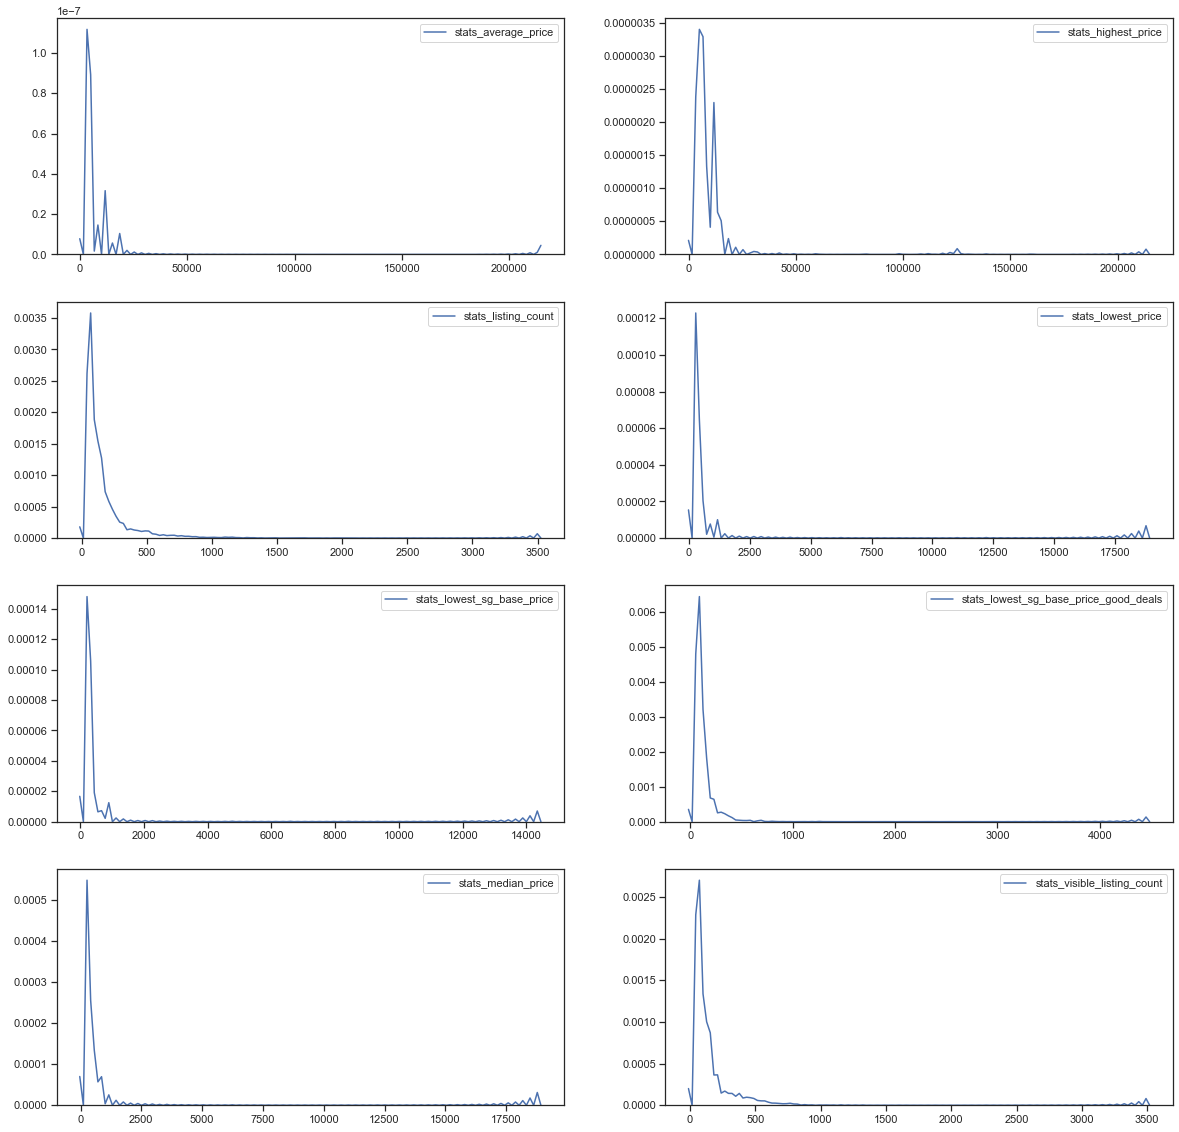

In [11]:
stats = ['stats_average_price', 'stats_highest_price', 'stats_listing_count',
       'stats_lowest_price',
       'stats_lowest_sg_base_price', 'stats_lowest_sg_base_price_good_deals',
       'stats_median_price', 'stats_visible_listing_count']

fig, axes = plt.subplots(4,2, figsize=(20,20))

for measure, ax in zip(stats, axes.flat):
    sns.kdeplot(df[measure], ax=ax)

In [12]:
df['taxonomies_name'].unique()

array(['theater', 'concert', 'sports'], dtype=object)

In [13]:
df['taxonomies_name'].value_counts()

theater    60545
concert    30634
sports     23189
Name: taxonomies_name, dtype: int64

In [14]:
df[df['taxonomies_name'] == 'sports']

access_method  \
24      {'employee_only': False, 'created_at': '2018-0...   
46                                                    NaN   
51                                                    NaN   
207                                                   NaN   
208     {'employee_only': False, 'created_at': '2015-1...   
212                                                   NaN   
213                                                   NaN   
278     {'employee_only': False, 'created_at': '2019-0...   
298     {'employee_only': False, 'created_at': '2015-0...   
301                                                   NaN   
345     {'employee_only': False, 'created_at': '2015-0...   
346                                                   NaN   
359     {'employee_only': False, 'created_at': '2015-1...   
361     {'employee_only': False, 'created_at': '2015-1...   
363                                                   NaN   
377     {'employee_only': False, 'created_at': '2018-0...   
383                                                   NaN   
398     {'employee_only': False, 'created_at': '2017-1...   
405                                                   NaN   
418     {'employee_only': False, 'created_at': '2015-0...   
420                                                   NaN   
443                                                   NaN   
445     {'employee_only': False, 'created_at': '2015-0...   
473                                                   NaN   
502     {'employee_only': False, 'created_at': '2019-0...   
504     {'employee_only': False, 'created_at': '2016-1...   
521                                                   NaN   
627     {'employee_only': False, 'created_at': '2015-0...   
635                                                   NaN   
646                                                   NaN   
...                                                   ...   
112923  {'employee_only': False, 'created_at': '2018-0...   
112924  {'employee_only': False, 'created_at': '2018-0...   
112946                                                NaN   
112983                                                NaN   
113003                                                NaN   
113037                                                NaN   
113126                                                NaN   
113128                                                NaN   
113144                                                NaN   
113149                                                NaN   
113155                                                NaN   
113173                                                NaN   
113182                                                NaN   
113216  {'employee_only': False, 'created_at': '2018-0...   
113227  {'employee_only': False, 'created_at': '2018-0...   
113292                                                NaN   
113304                                                NaN   
113318                                                NaN   
113359                                                NaN   
113423                                                NaN   
113503  {'employee_only': False, 'created_at': '2018-0...   
113512  {'employee_only': False, 'created_at': '2018-0...   
113539                                                NaN   
113550                                                NaN   
113567                                                NaN   
113576                                                NaN   
113702                                                NaN   
113770                                                NaN   
113797  {'employee_only': False, 'created_at': '2018-0...   
113801  {'employee_only': False, 'created_at': '2018-0...   

              announce_date  \
24      2019-07-31T00:00:00   
46      2019-07-30T00:00:00   
51      2019-06-25T00:00:00   
207     2019-08-01T00:00:00   
208     2019-08-13T00:00:00   
212     2019-03-16T00:00:00   
213     2019-05-12T00:00:00   
278     2019-

# Looking at Correlations between Features

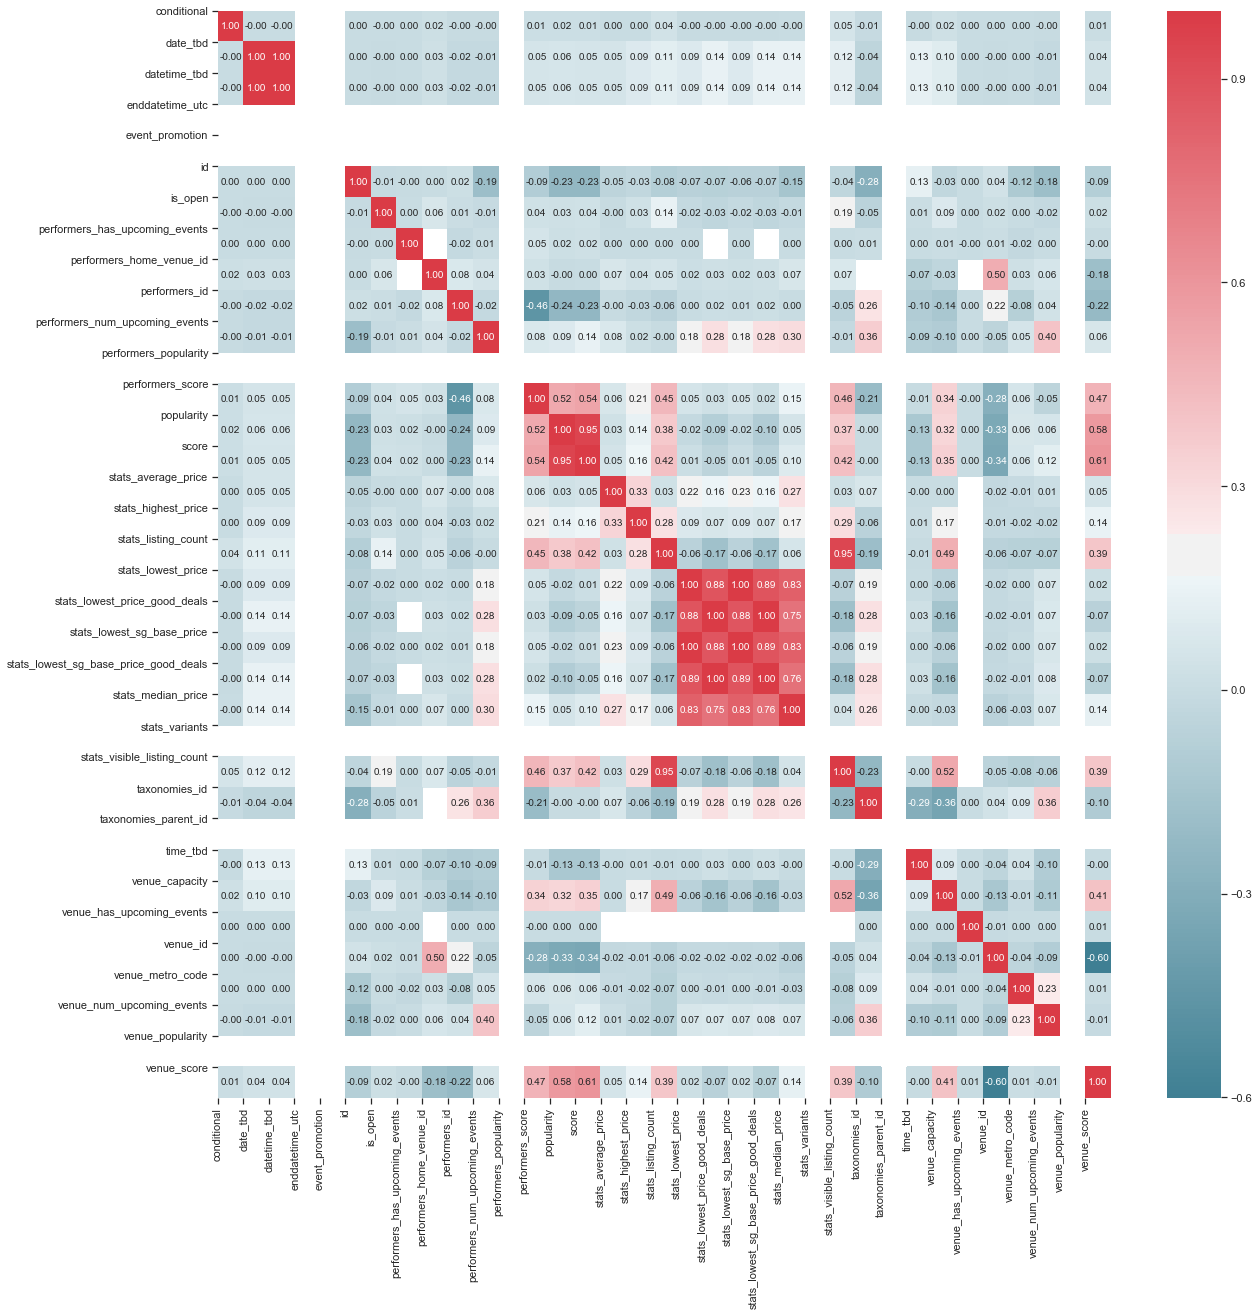

In [15]:
heatMap(df)

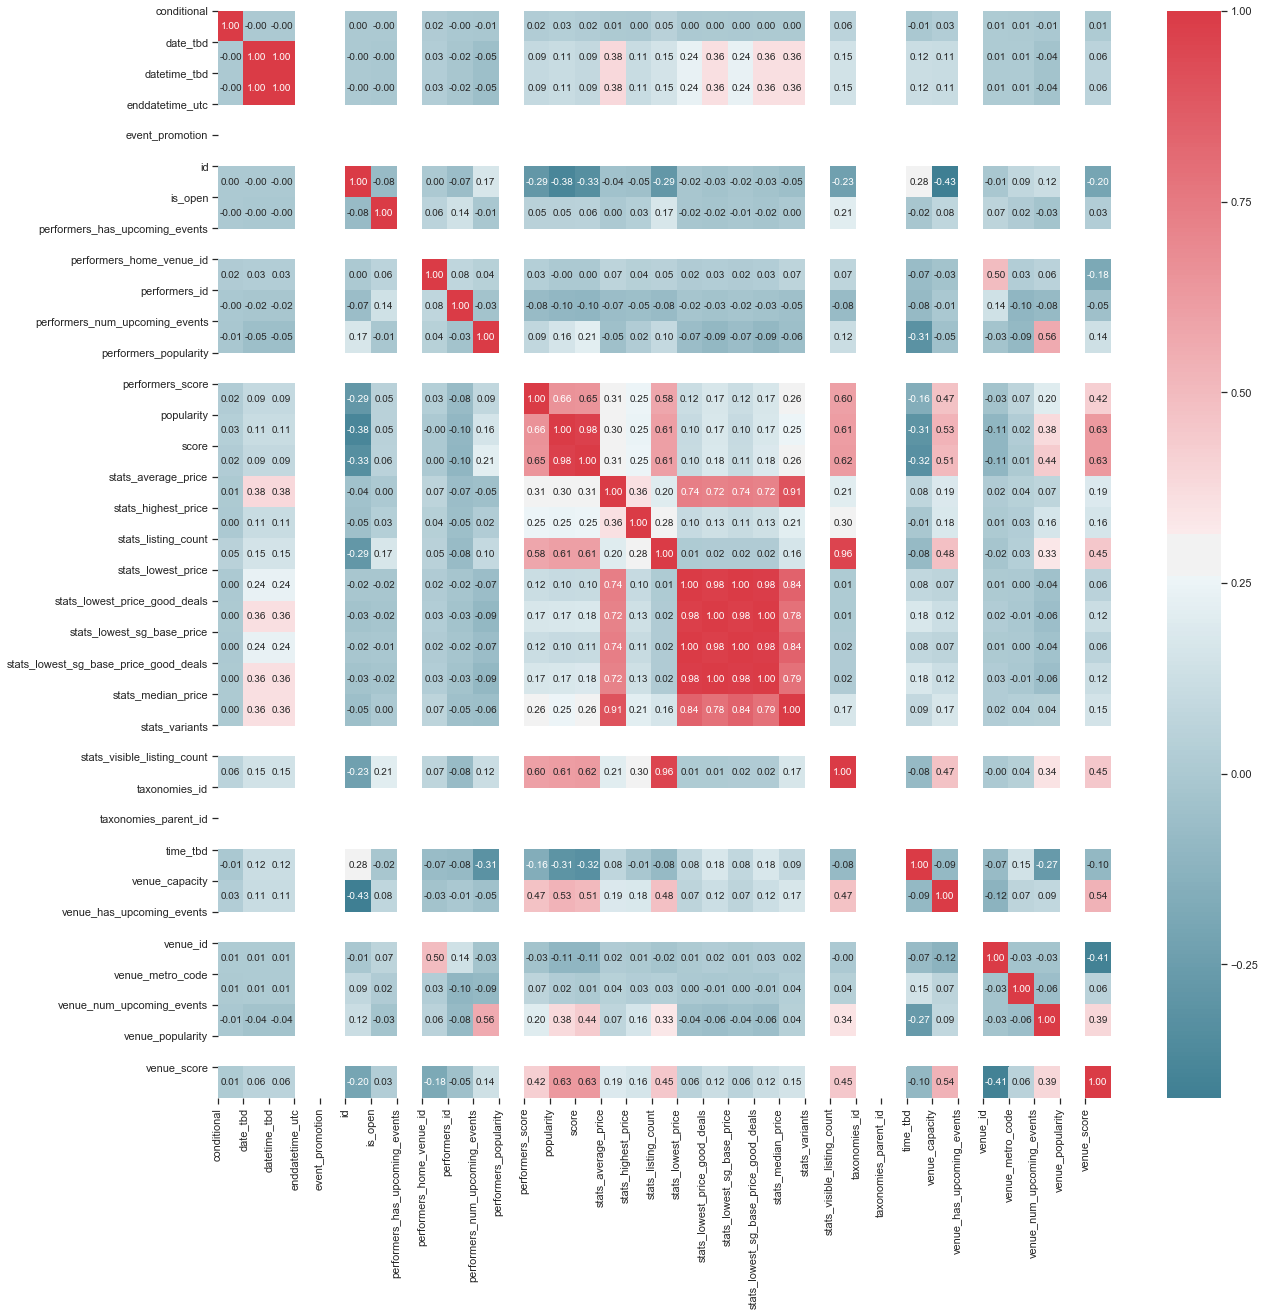

In [16]:
heatMap(df[df['taxonomies_name'] == 'sports'])

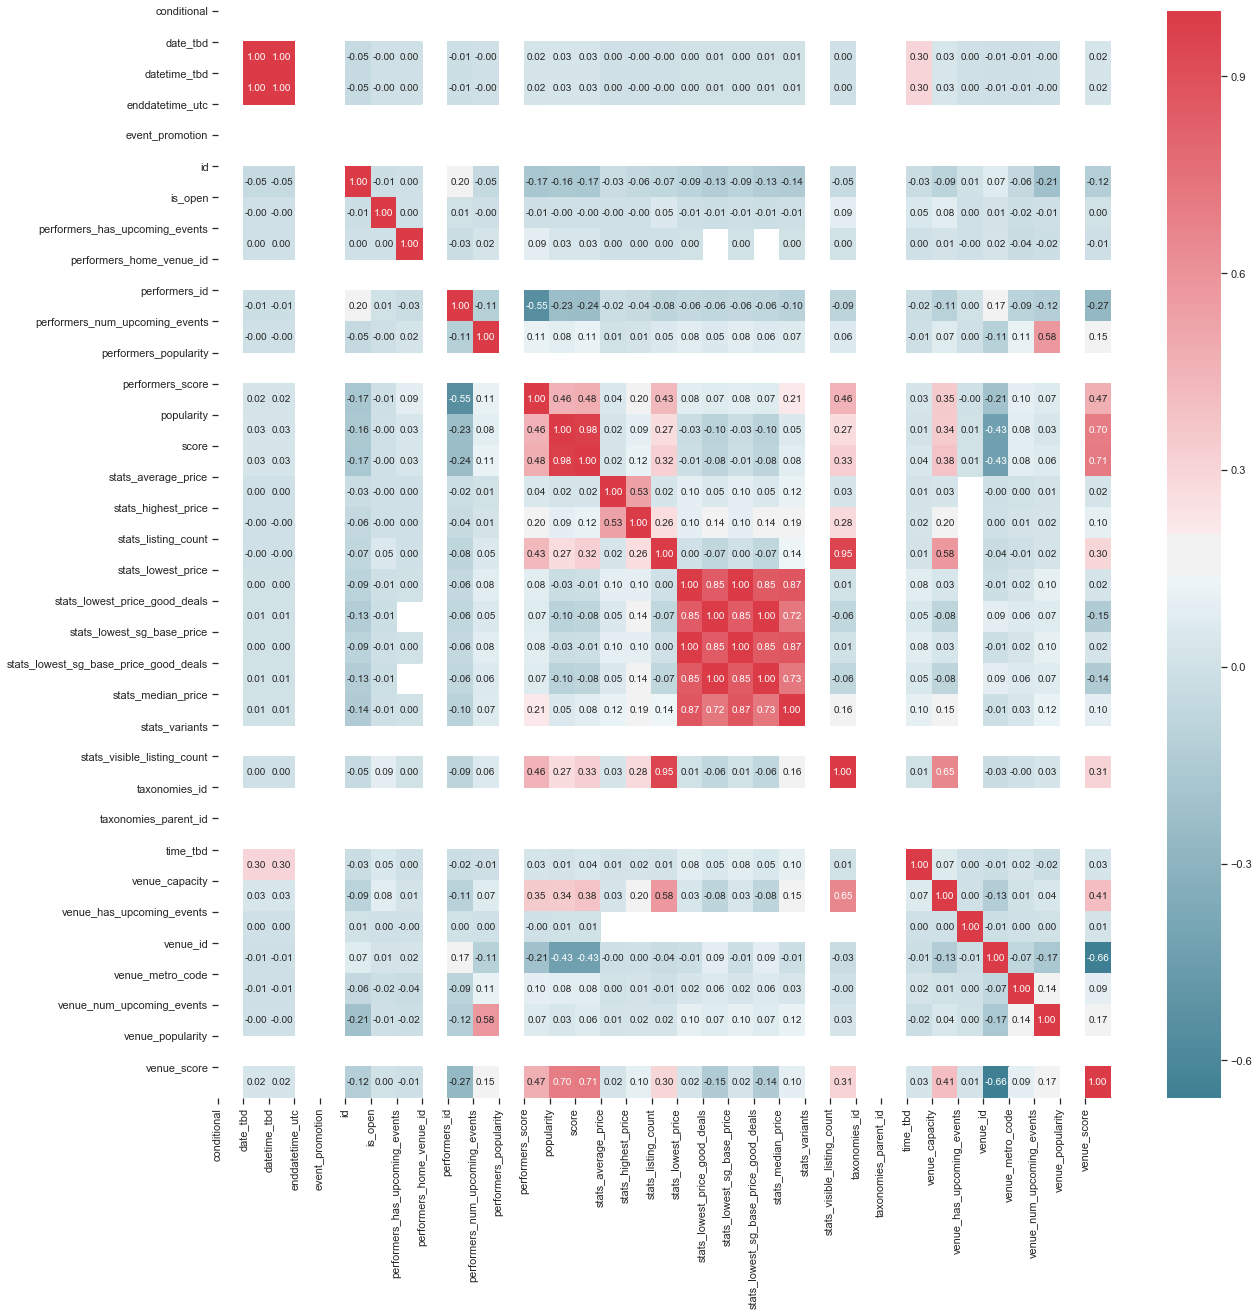

In [17]:
heatMap(df[df['taxonomies_name'] == 'concert'])

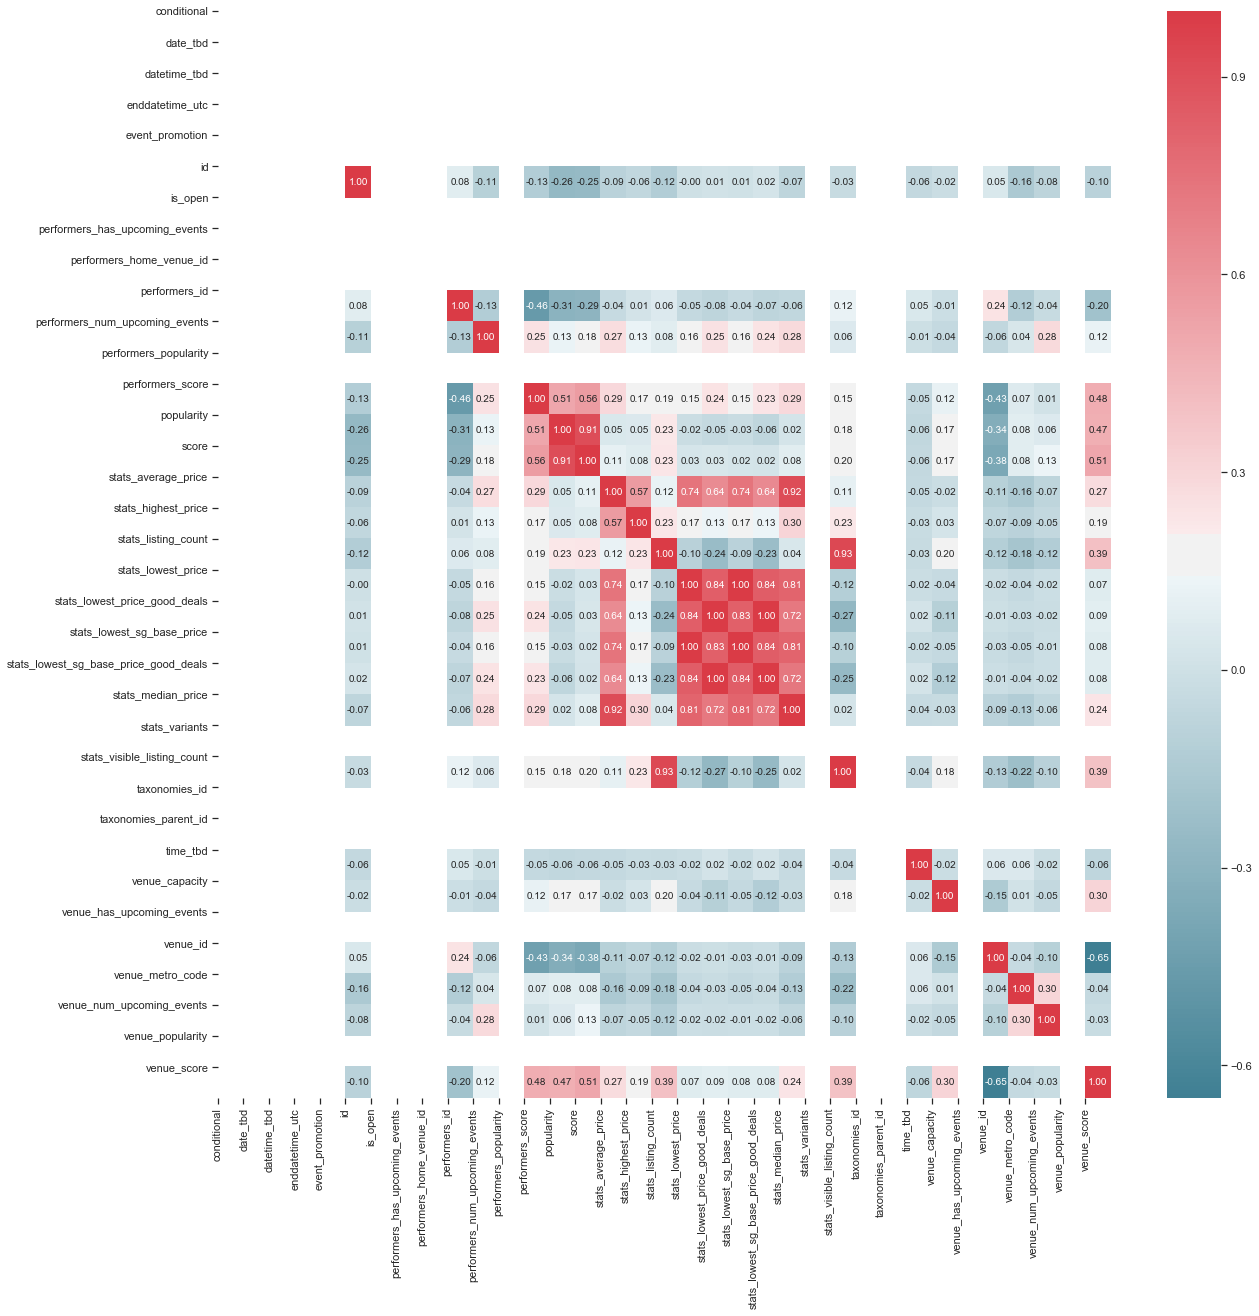

In [18]:
heatMap(df[df['taxonomies_name'] == 'theater'])

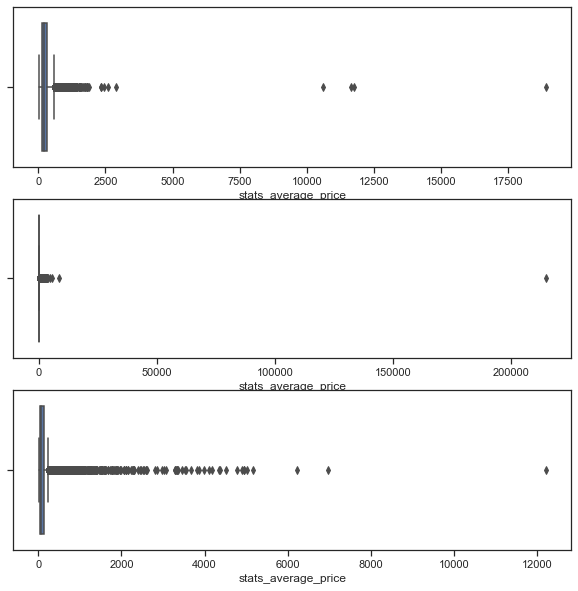

In [19]:
fig, axes = plt.subplots(3,1, figsize = (10,10))

for event, ax in zip(df['taxonomies_name'].unique(), axes.flat):
    sns.boxplot(df[df['taxonomies_name'] == event]['stats_average_price'], ax=ax);

In [69]:
df_filtered = df[~df['stats_average_price'].isnull()]
df_filtered = df[~df['stats_lowest_sg_base_price'].isnull()]

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86448 entries, 0 to 114367
Data columns (total 89 columns):
access_method                            13775 non-null object
announce_date                            86448 non-null object
announcements                            86448 non-null object
conditional                              86448 non-null bool
created_at                               86448 non-null object
date_tbd                                 86448 non-null bool
datetime_local                           86448 non-null object
datetime_tbd                             86448 non-null bool
datetime_utc                             86448 non-null object
description                              18 non-null object
enddatetime_utc                          0 non-null float64
event_promotion                          0 non-null float64
general_admission                        7789 non-null object
id                                       86448 non-null int64
is_open                  

# Filtering off of Z-score

In [131]:
z_scores = np.abs(stats.zscore(df_filtered['stats_average_price']))
threshold = 2
print(np.where(z_scores >= threshold))
z_scores

(array([   77,   124,   172, ..., 86219, 86240, 86262]),)


array([0.85028158, 0.79839807, 0.29115563, ..., 0.26803331, 1.16734748,
       1.16734748])

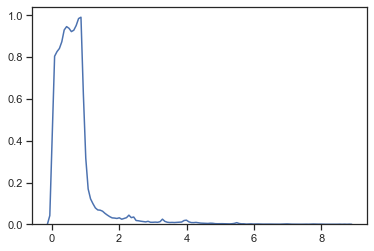

In [132]:
sns.kdeplot(z_scores);

In [133]:
# Filter by Z-Score: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
df_filtered = df_filtered[(z_scores < threshold)]
len(df_filtered)

82367

theater
concert
sports


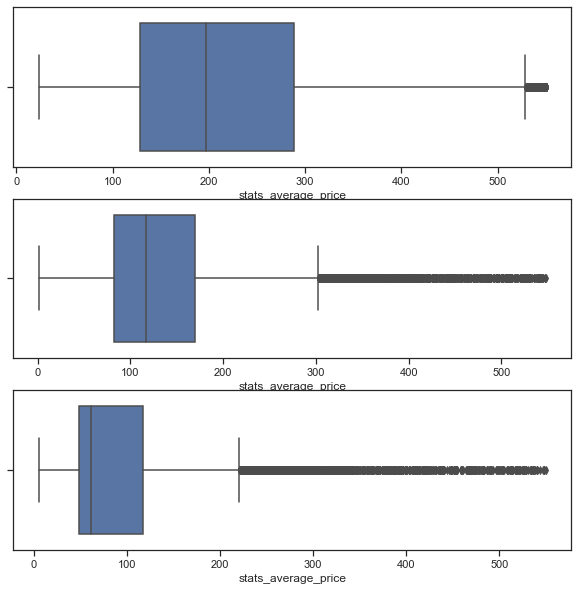

In [134]:
fig, axes = plt.subplots(3,1, figsize = (10,10))

for event, ax in zip(df_filtered['taxonomies_name'].unique(), axes.flat):
    print(event)
    sns.boxplot(df_filtered[df_filtered['taxonomies_name'] == event]['stats_average_price'], ax=ax);

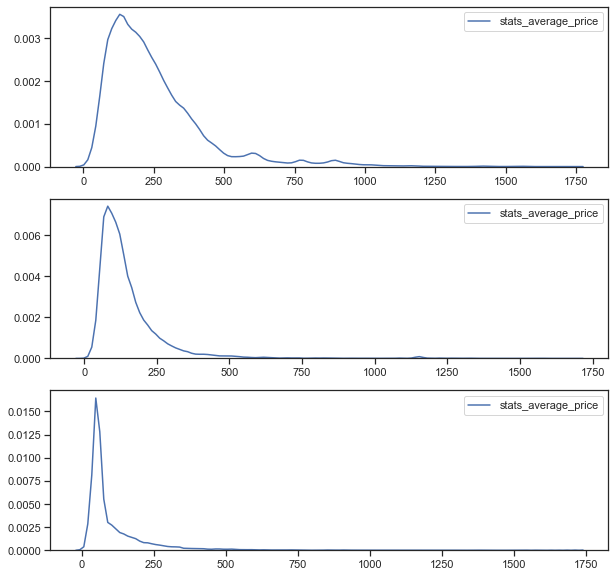

In [74]:
fig, axes = plt.subplots(3,1, figsize = (10,10))

for event, ax in zip(df_filtered['taxonomies_name'].unique(), axes.flat):
    sns.kdeplot(df_filtered[df_filtered['taxonomies_name'] == event]['stats_average_price'], ax=ax);

In [135]:
genres_avgprice = df_filtered[~df_filtered['taxonomies_name'].isnull()][['taxonomies_name','stats_average_price']]
genres_avgprice


groupedtickets = {}

#Making arrays of tick prices per genre for kw test
for grp in genres_avgprice.taxonomies_name.unique():
    groupedtickets[grp] = genres_avgprice['stats_average_price'][genres_avgprice['taxonomies_name']==grp].values
    print(str(grp) + " " + str(genres_avgprice[genres_avgprice['taxonomies_name']==grp]['stats_average_price'].mean()))

# print(groupedtickets)

args = groupedtickets.values()
            
H,p = stats.kruskal(*args)

print("\nKruskal")
print(H,p)

theater 216.0927743280212
concert 140.25207126948774
sports 99.27036582726026

Kruskal
19840.063660391923 0.0


I think taxnomie name has to do something with average price!

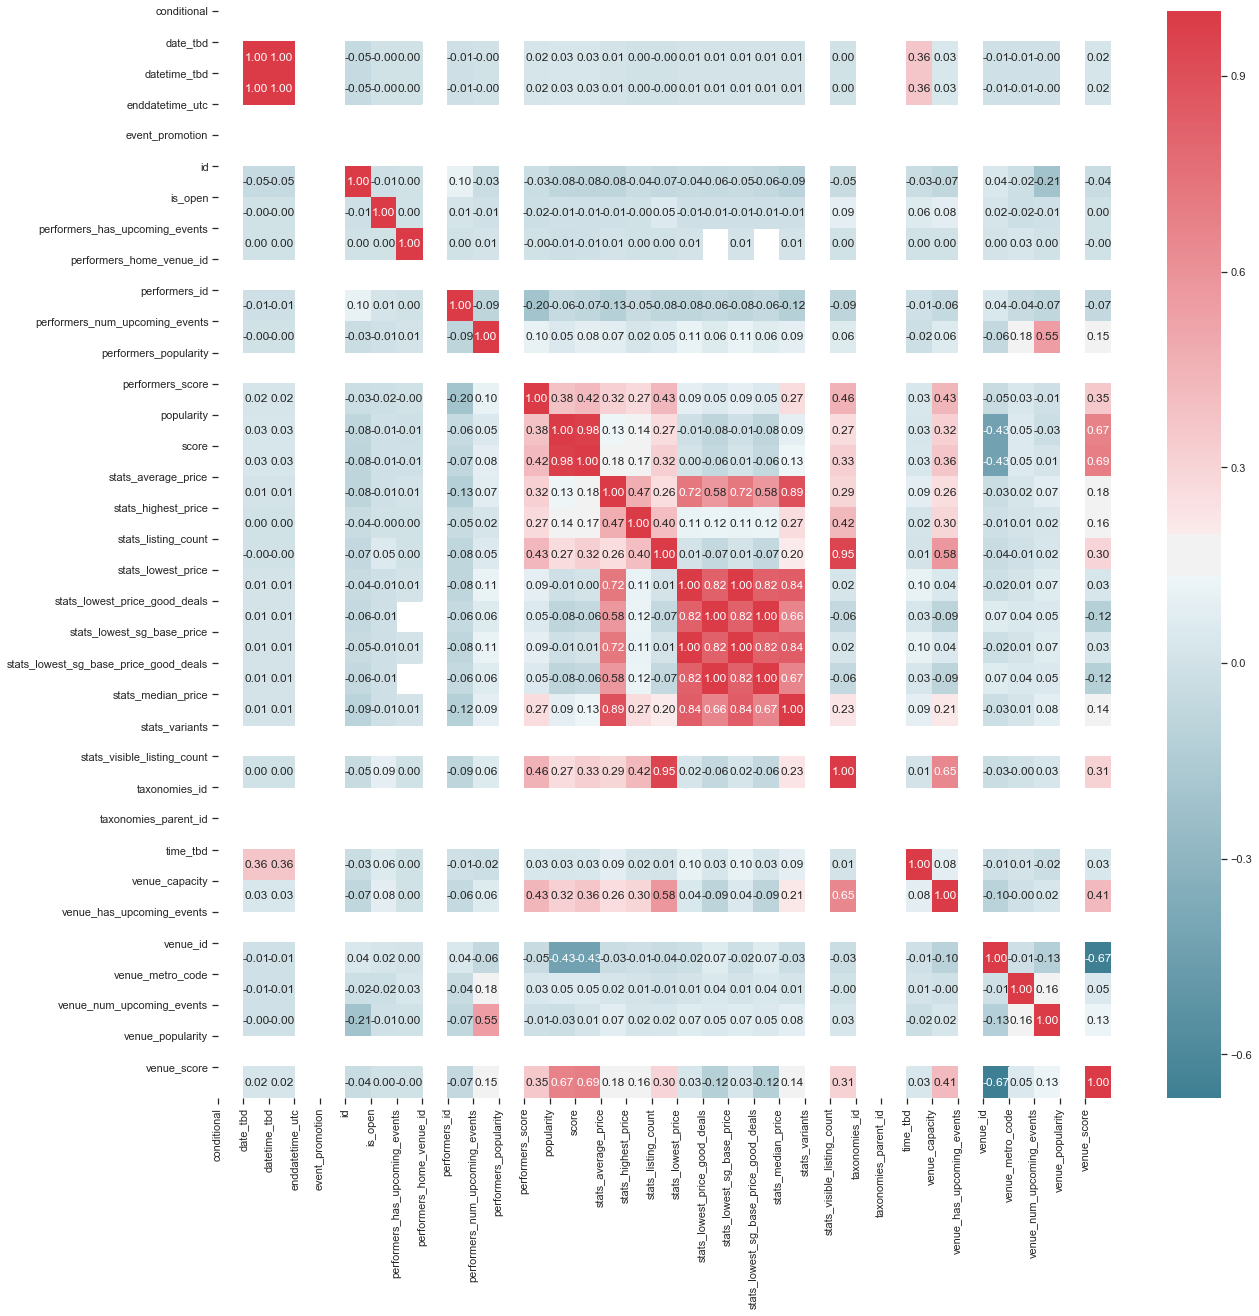

In [76]:
heatMap(df_filtered[df_filtered['taxonomies_name'] == 'concert'])

In [77]:
features= ['datetime_local', 'stats_average_price',
       'performers_genres', 'performers_has_upcoming_events',
       'performers_num_upcoming_events', 'performers_type',
       'popularity', 'score', 
       'stats_dq_bucket_counts', 'stats_highest_price', 'stats_listing_count',
       'stats_lowest_price', 
       'stats_lowest_sg_base_price', 'stats_lowest_sg_base_price_good_deals',
       'stats_median_price','stats_visible_listing_count',
        'venue_capacity', 'venue_city',
       'venue_location', 'venue_name', 'venue_postal_code',
       'venue_score', 'venue_state']


df_filtered[features].corr()

stats_average_price  \
stats_average_price                               1.000000   
performers_has_upcoming_events                    0.003732   
performers_num_upcoming_events                    0.373457   
popularity                                        0.104761   
score                                             0.163541   
stats_highest_price                               0.284784   
stats_listing_count                               0.133915   
stats_lowest_price                                0.721800   
stats_lowest_sg_base_price                        0.725041   
stats_lowest_sg_base_price_good_deals             0.691588   
stats_median_price                                0.935438   
stats_visible_listing_count                       0.120180   
venue_capacity                                   -0.026191   
venue_score                                       0.205513   

                                       performers_has_upcoming_events  \
stats_average_price                                          0.003732   
performers_has_upcoming_events                               1.000000   
performers_num_upcoming_events                               0.002973   
popularity                                                  -0.007803   
score                                                       -0.004195   
stats_highest_price                                          0.001061   
stats_listing_count                                          0.002136   
stats_lowest_price                                           0.003613   
stats_lowest_sg_base_price                                   0.003659   
stats_lowest_sg_base_price_good_deals                             NaN   
stats_median_price                                           0.003648   
stats_visible_listing_count                                  0.002233   
venue_capacity                                               0.001711   
venue_score                                                 -0.000352   

                                       performers_num_upcoming_events  \
stats_average_price                                          0.373457   
performers_has_upcoming_events                               0.002973   
performers_num_upcoming_events                               1.000000   
popularity                                                   0.049078   
score                                                        0.096215   
stats_highest_price                                          0.031494   
stats_listing_count                                         -0.001572   
stats_lowest_price                                           0.294657   
stats_lowest_sg_base_price                                   0.295314   
stats_lowest_sg_base_price_good_deals                        0.325959   
stats_median_price                                           0.392800   
stats_visible_listing_count                                 -0.014146   
venue_capacity                                              -0.124462   
venue_score                                                  0.033090   

                                       popularity     score  \
stats_average_price                      0.104761  0.163541   
performers_has_upcoming_events          -0.007803 -0.004195   
performers_num_upcoming_events           0.049078  0.096215   
popularity                               1.000000  0.939775   
score                                    0.939775  1.000000   
stats_highest_price                      0.153625  0.178630   
stats_listing_count                      0.375766  0.417883   
stats_lowest_price                      -0.027692  0.011404   
stats_lowest_sg_base_price              -0.031026  0.008456   
stats_lowest_sg_base_price_good_deals   -0.124060 -0.079862   
stats_median_price                       0.059148  0.112408   
stats_visible_listing_count              0.368535  0.422565   
venue_capacity                           0.319054  0.350037   
venue_score                       

In [78]:
len(features)

23

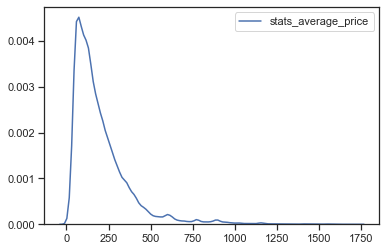

In [79]:
sns.kdeplot(df_filtered['stats_average_price'])

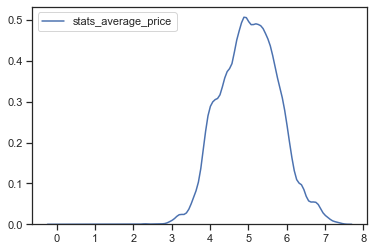

In [80]:
sns.kdeplot(np.log(df_filtered['stats_average_price']))

In [136]:
import datetime

download_date = datetime.date(2019, 10, 8)
df_filtered['datetime_local'] =  pd.to_datetime(df_filtered['datetime_local']).dt.date

df_filtered
df_filtered['days_to_event'] = df_filtered['datetime_local'] - download_date
df_filtered['days_to_event'] = df_filtered['days_to_event'].dt.days

/Users/linhchau/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/linhchau/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/linhchau/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

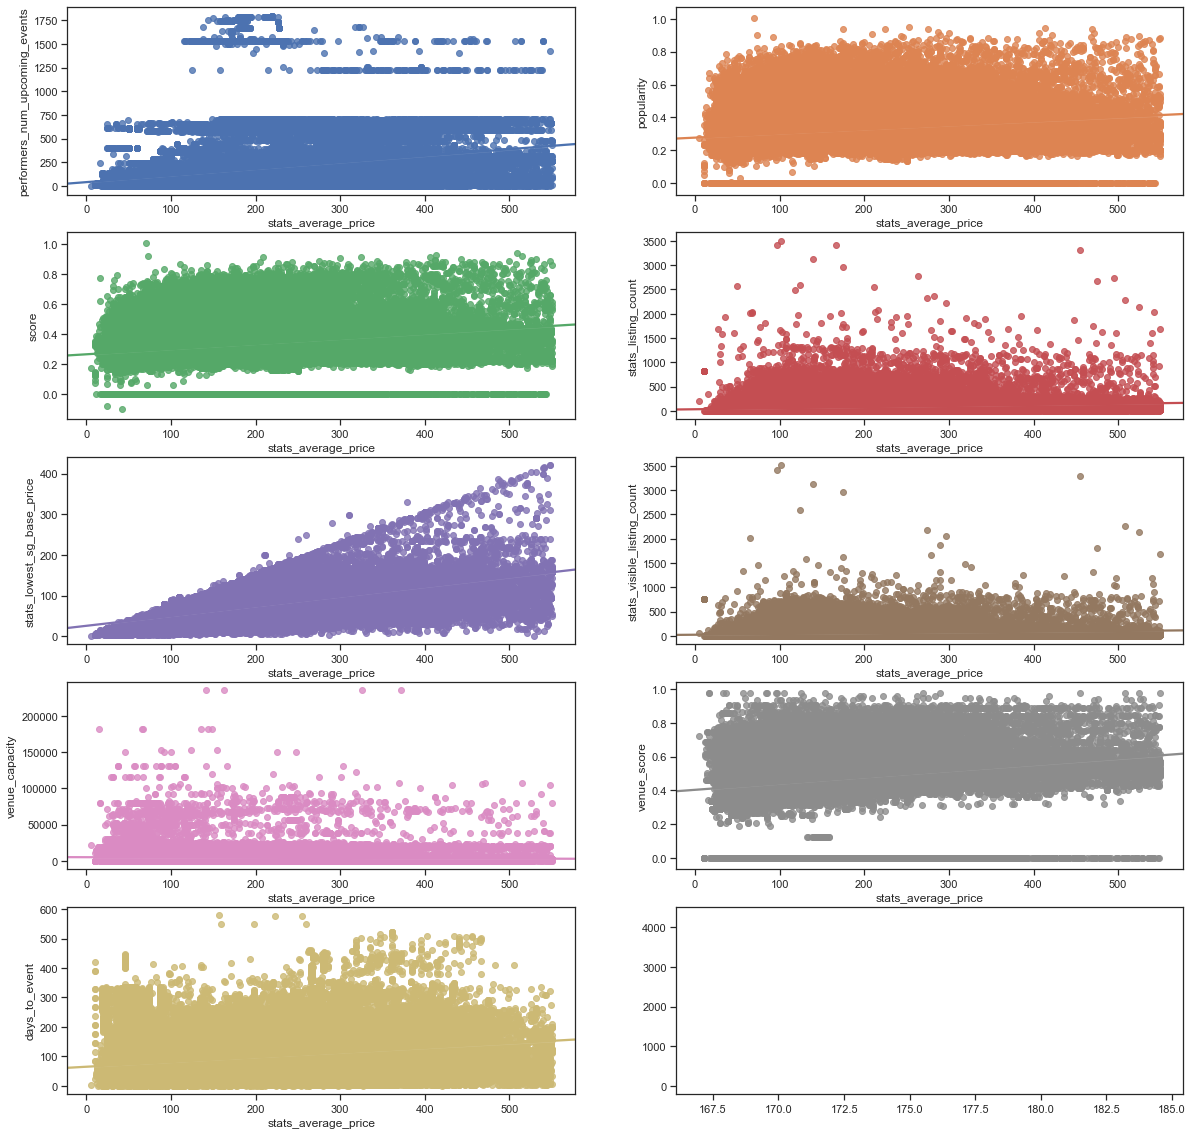

In [188]:
# let's look at log transforming
features= [
       'performers_num_upcoming_events',
       'popularity', 'score', 
       'stats_listing_count',
       'stats_lowest_sg_base_price',
       'stats_visible_listing_count',
        'venue_capacity',
       'venue_score','days_to_event']

fig, axes = plt.subplots(5,2, figsize=(20,20))

for measure,ax in zip(features, axes.flat):
    sns.regplot(df_filtered['stats_average_price'], df_filtered[measure], ax = ax);

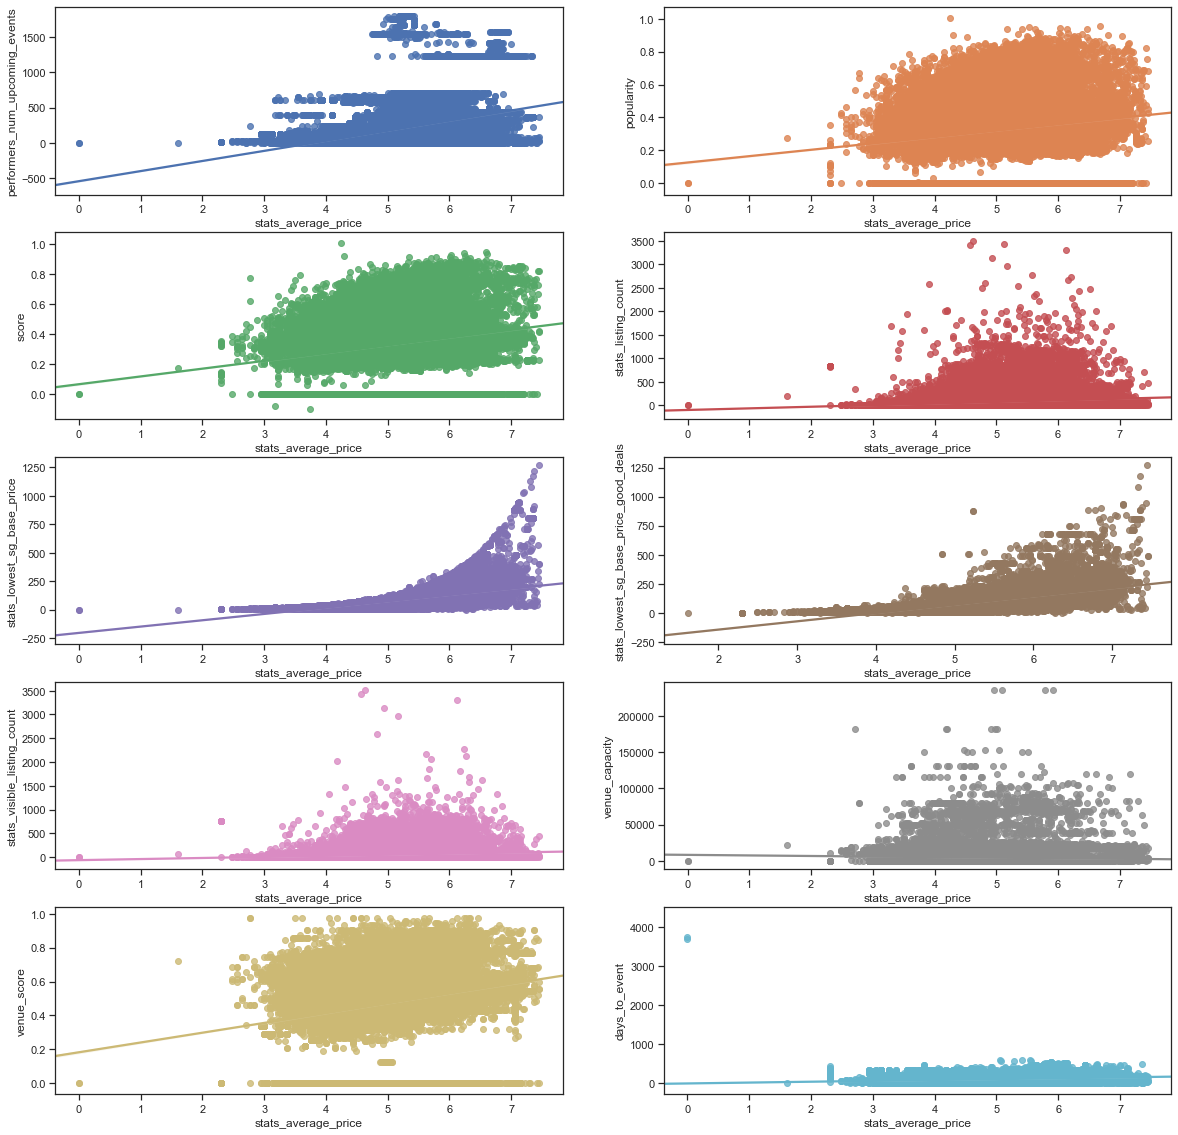

In [126]:
fig, axes = plt.subplots(5,2, figsize=(20,20))
for measure,ax in zip(features, axes.flat):
    sns.regplot(np.log(df_filtered['stats_average_price']), df_filtered[measure], ax = ax);

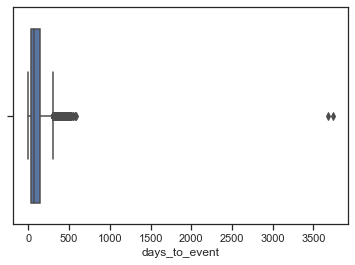

In [147]:
sns.boxplot(df_filtered['days_to_event'])

In [189]:
# filter out events that are more than 1000 days out
df_filtered = df_filtered[df_filtered['days_to_event'] < 1000]

df_filtered[features].isnull().sum()

performers_num_upcoming_events    0
popularity                        0
score                             0
stats_listing_count               0
stats_lowest_sg_base_price        0
stats_visible_listing_count       0
venue_capacity                    0
venue_score                       0
days_to_event                     0
dtype: int64

# Trying most simple Linear Regression

In [190]:
df_filtered_concert = df_filtered[df_filtered['taxonomies_name'] == 'concert']

In [191]:
# train test split

y = df_filtered_concert['stats_average_price']
X = df_filtered_concert.drop('stats_average_price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 193)

In [192]:
def linear_regression(X_train, y_train, X_test, y_test):
    model = LinearRegression().fit(X_train, y_train)
    model.score(X_train, y_train)
    
    # Coeff
    print(model.get_params)
    print(model.coef_)
    
    # Making Predictions using the testing set
    y_pred = model.predict(X_test)
   
    # Mean squared error
    print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
    
    # R2
    print("R2: %2f" % r2_score(y_test, y_pred))
    
    #Let's try to studentize them: divide the resideual by the estimate of the stdev of the residuals. 
    fig, ax = plt.subplots()
    fig.set_size_inches(10,8)
    mask_outliers = studresidplot(model,X_train,y_train,threshold=2, ax = ax)
    
    #QQ plot: to chck if residuals are not normally distributed
    vals = {'Studentized Residuals': (y_train-model.predict(X_train))/rse(model,X_train,y_train), 'Predicted Values': model.predict(X_train)}

    ax = sm.graphics.qqplot(vals['Studentized Residuals'], line='45')
    
    # VIF
#     print("VIF: %2f" % variance_inflation_factor(X_train.values,1))


# Venue Score

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>
[110.7510991]
Mean squared error: 7211.46
R2: 0.042688


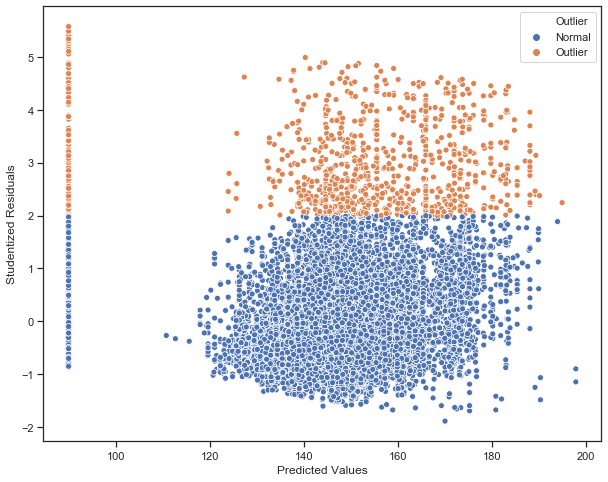

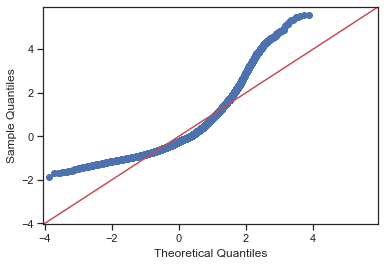

In [193]:
feats1 = ['venue_score']
linear_regression(X_train[feats1], y_train, X_test[feats1], y_test)

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>
[0.76576885]
Mean squared error: 0.28
R2: 0.062132


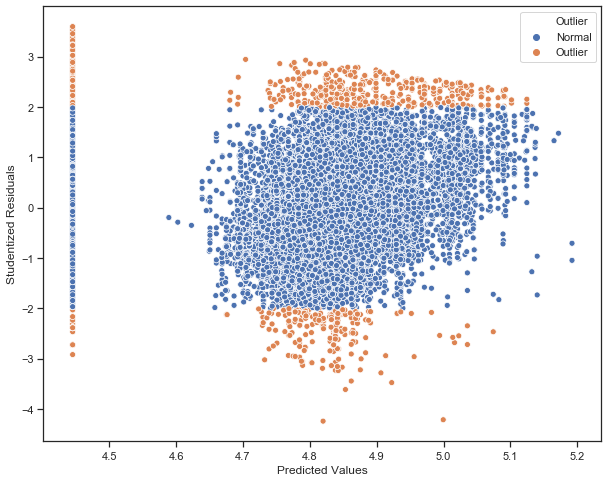

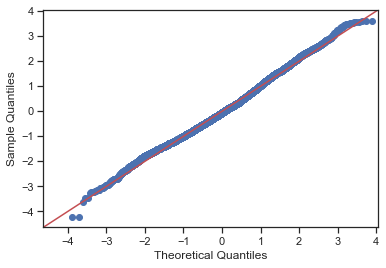

In [194]:
linear_regression(X_train[feats1], np.log(y_train), X_test[feats1], np.log(y_test))

# Venue Capacity

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>
[0.00467135]
Mean squared error: 6747.17
R2: 0.104321


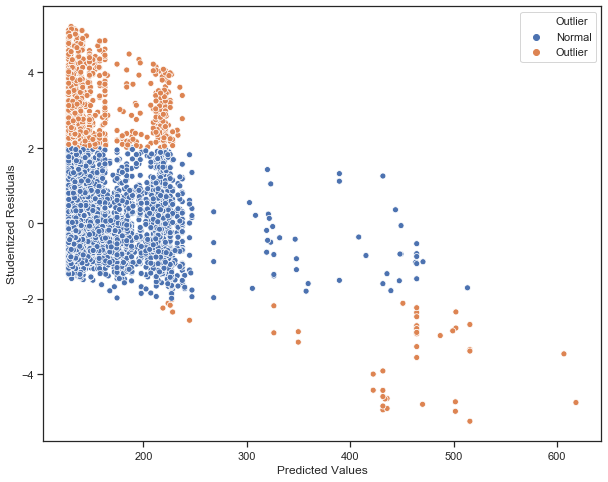

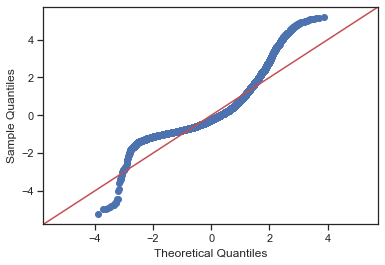

In [195]:
feats2 = ['venue_capacity']
linear_regression(X_train[feats2], y_train, X_test[feats2], y_test)

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>
[2.78281912e-05]
Mean squared error: 0.27
R2: 0.097995


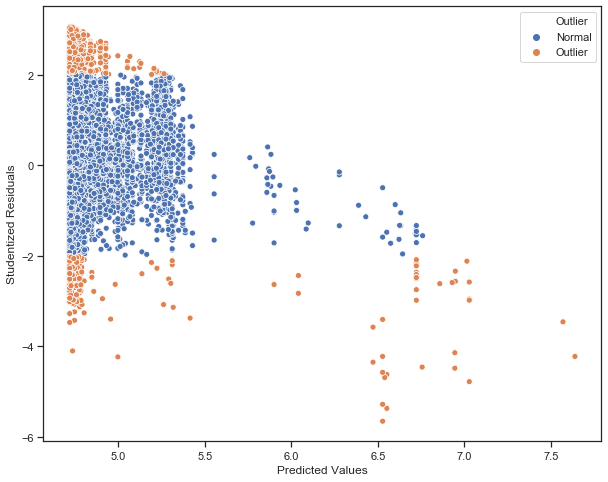

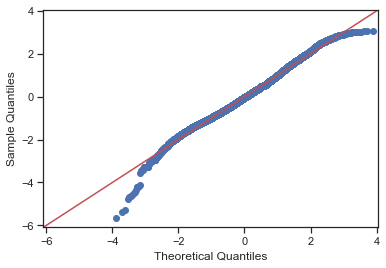

In [196]:
linear_regression(X_train[feats2], np.log(y_train), X_test[feats2], np.log(y_test))

# Base price

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>
[0.00964874]
Mean squared error: 0.19
R2: 0.369074


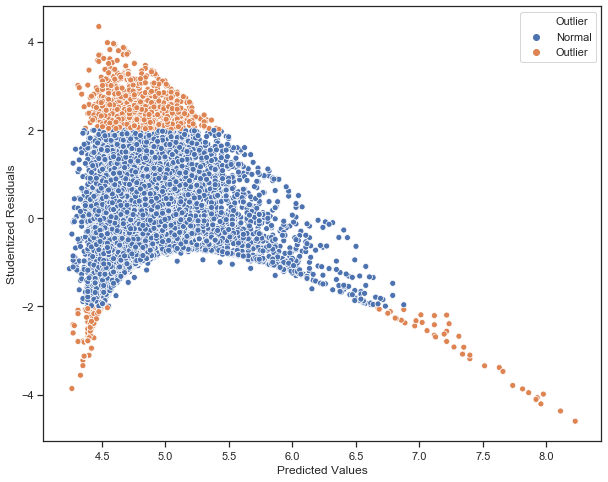

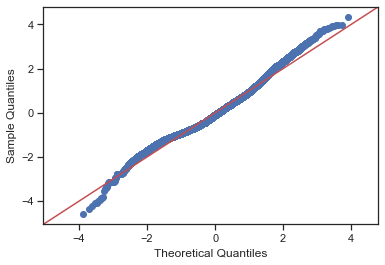

In [197]:
feats3 = ['stats_lowest_sg_base_price']
linear_regression(X_train[feats3], np.log(y_train), X_test[feats3], np.log(y_test))

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>
[0.71358764]
Mean squared error: 0.17
R2: 0.420357


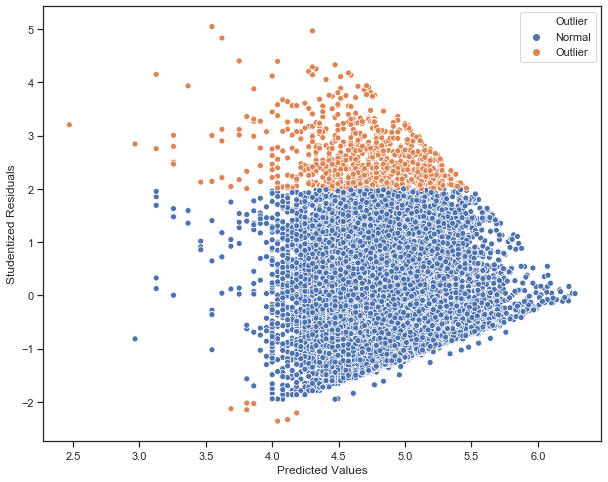

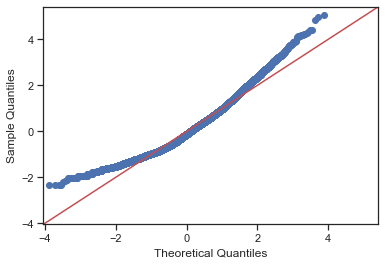

In [199]:
linear_regression(np.log(X_train[feats3]), np.log(y_train), np.log(X_test[feats3]), np.log(y_test))

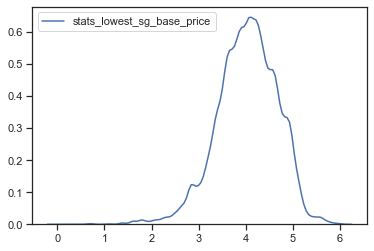

In [200]:
sns.kdeplot(np.log(df_filtered['stats_lowest_sg_base_price']))

# Days since announcement

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>
[0.40198887]
Mean squared error: 7041.02
R2: 0.065313


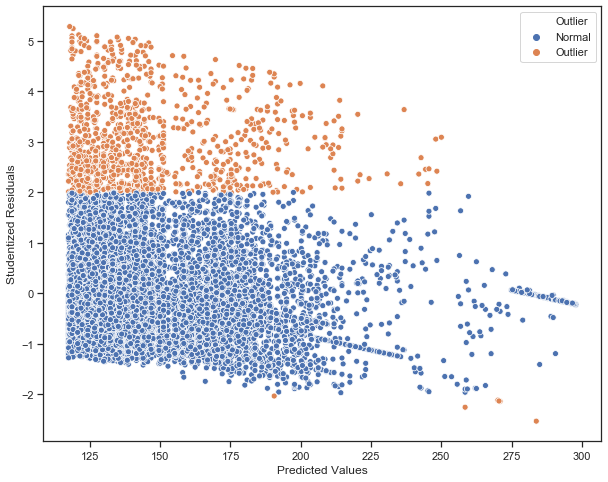

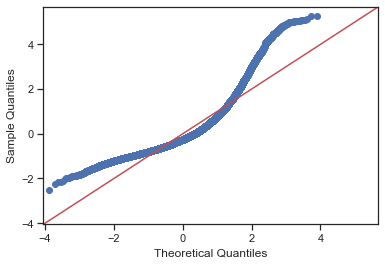

In [201]:
feats3 = ['days_to_event']
linear_regression(X_train[feats3], y_train, X_test[feats3], y_test)

# Score

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>
[0.6646236]
Mean squared error: 0.28
R2: 0.056884


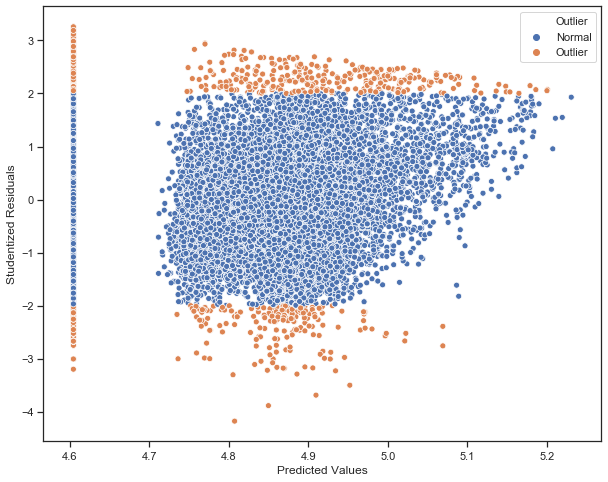

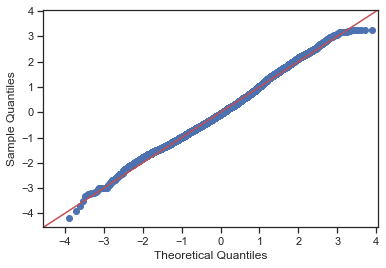

In [202]:
feats4 = ['score']
linear_regression(X_train[feats4], np.log(y_train), X_test[feats4], np.log(y_test))

# stats_visible_listing_count

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>
[0.42930338]
Mean squared error: 6389.00
R2: 0.151868


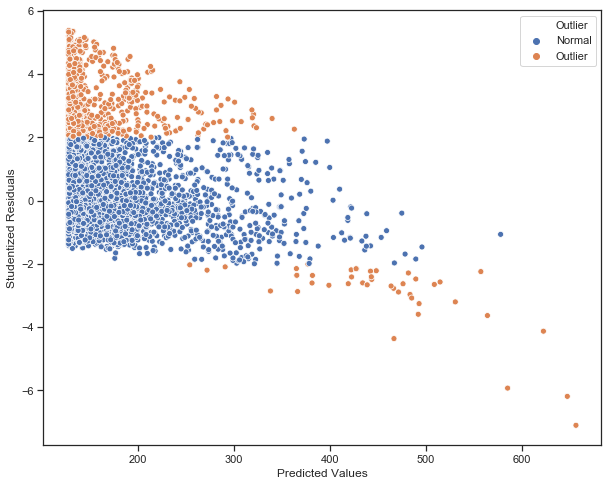

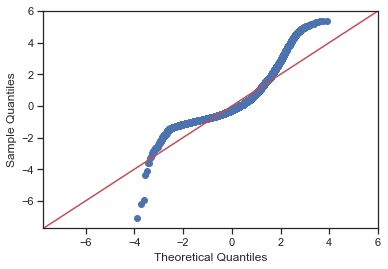

In [223]:
feats5 = ['stats_visible_listing_count']
linear_regression(X_train[feats5], y_train, X_test[feats5], y_test)

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>
[0.00252656]
Mean squared error: 0.26
R2: 0.125434


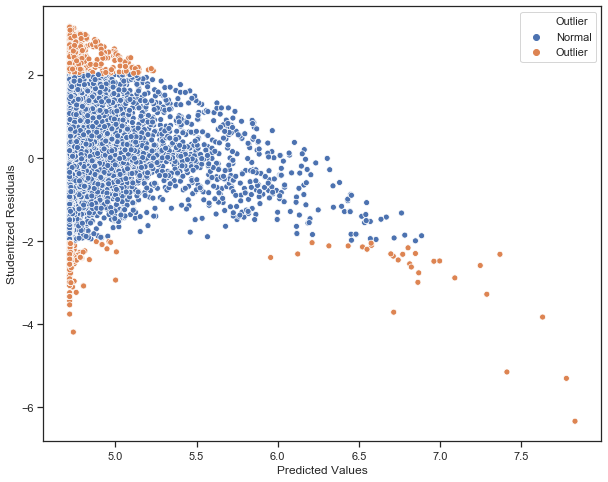

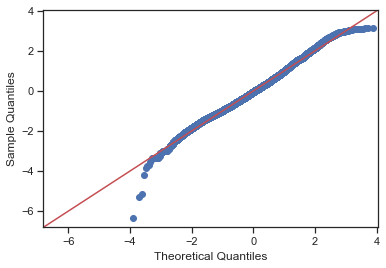

In [224]:
linear_regression(X_train[feats5], np.log(y_train), X_test[feats5], np.log(y_test))

# Random Forest Try

In [215]:
X_train[features]

performers_num_upcoming_events  popularity  score  \
25532                               26       0.356  0.307   
29601                                6       0.527  0.471   
27441                               21       0.557  0.519   
7645                                 7       0.315  0.237   
31936                               28       0.279  0.240   
32634                                7       0.000  0.000   
54210                               26       0.269  0.244   
90682                               10       0.000  0.000   
47075                               11       0.527  0.500   
53035                                2       0.000  0.000   
8003                                11       0.561  0.489   
29433                               10       0.284  0.236   
97727                                6       0.236  0.252   
25615                               20       0.497  0.442   
79055                              207       0.000  0.000   
8738                                34       0.000  0.000   
75267                               17       0.595  0.596   
58941                               13       0.000  0.000   
7036                                27       0.000  0.000   
80784                                6       0.000  0.000   
1184                                11       0.492  0.383   
46715                                1       0.417  0.352   
574                                 15       0.330  0.230   
113101                               2       0.401  0.305   
99493                              207       0.000  0.000   
85399                                3       0.201  0.216   
925                                  5       0.405  0.326   
11828                                1       0.000  0.000   
9645                                16       0.000  0.000   
27297                                2       0.000  0.000   
...                                ...         ...    ...   
75268                               17       0.430  0.438   
808                                  8       0.591  0.476   
33077                                9       0.000  0.000   
31295                                2       0.483  0.419   
76009                                4       0.350  0.329   
41463                               17       0.285  0.256   
27582                               27       0.454  0.351   
3116                                15       0.325  0.242   
30655                                1       0.436  0.347   
25973                               13       0.000  0.000   
11968                               15       0.331  0.268   
75260                                9       0.436  0.370   
15589                                8       0.503  0.427   
8070                                11       0.639  0.557   
29589                                3       0.000  0.000   
60048                               24       0.316  0.295   
95168                               15       0.000  0.000   
2960                                 6       0.514  0.415   
90629                               41       0.000  0.000   
35725                               32       0.596  0.597   
34603                                9       0.316  0.260   
16174                               33       0.468  0.407   
44299                                5       0.577  0.499   
7688                                 9       0.283  0.210   
15337                               17       0.431  0.367   
78507                               40       0.293  0.314   
42054                              290       0.573  0.508   
99446                               38       0.000  0.000   
53133                               37       0.553  0.546   
50404                               24       0.341  0.313   

        stats_listing_count  stats_lowest_sg_base_price  \
25532                  85.0                        56.0   
29601                  38.0                        48.0   
27441                  42.0                     

In [216]:
# Test random forest

#Train and fit model
rf = RandomForestRegressor(n_estimators = 1000,
                           max_features = 'auto',
                           random_state = 0
                            )

In [218]:
rf.fit(X_train[features], y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [219]:
rf_pred = rf.predict(X_test[features])

In [220]:
print(f"accuracy = {rf.score(X_test[features], y_test)}")

accuracy = 0.717715597026658


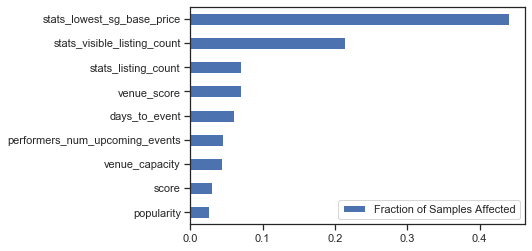

In [221]:
# Plot feature importance
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_}, index=X_train[features].columns)

feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh')

In [ ]:
# Trying a paramete search
model = RandomForestRegressor()

param_grid = {
    "n_estimators": [10, 100, 1000, 10000], # num of trees
    "max_depth": [2,5,10],
    "max_features": ['auto', 'sqrt', 'log2'] # num of features when considering where to split
}

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, iid=False)
start = time()
grid_search.fit(X_train[features], y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))

# Let's use the RF to Inform the Linear Regression before doing Lasso

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>
[1.48510678 0.41264214]
Mean squared error: 3859.79
R2: 0.487617


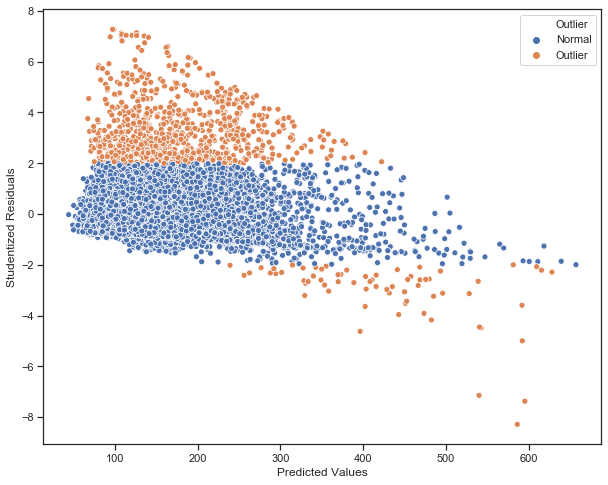

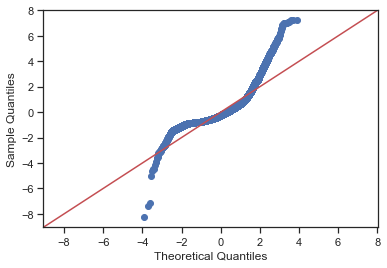

In [227]:
feats6 = ['stats_lowest_sg_base_price', 'stats_visible_listing_count']
linear_regression(X_train[feats6], y_train, X_test[feats6], y_test)

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>
[0.00951744 0.00241979]
Mean squared error: 0.15
R2: 0.482635


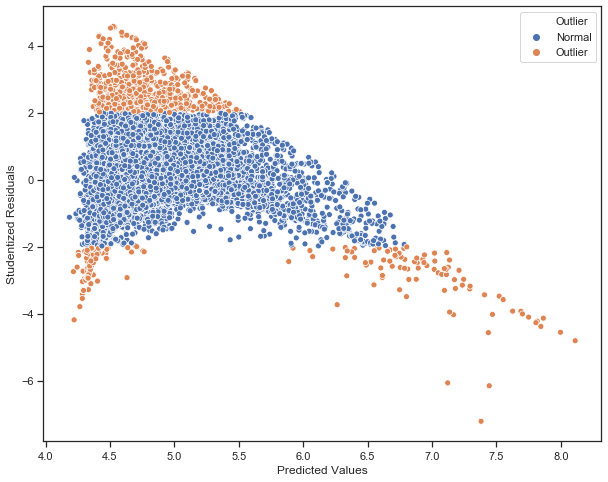

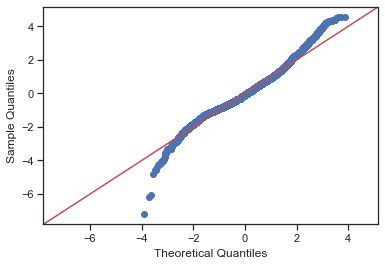

In [228]:
linear_regression(X_train[feats6], np.log(y_train), X_test[feats6], np.log(y_test))

Maybe a transformation will work?

## Lasso

In [ ]:
lasso = Lasso()
lasso.fit(X_train[features], y_train)

train_score=lasso.score(X_train[features],y_train)
test_score=lasso.score(X_test[features],y_test)
coeff_used = np.sum(lasso.coef_!=0)
print "training score:", train_score 
print "test score: ", test_score
print "number of features used: ", coeff_used

In [ ]:
# Grid search

model = Lasso()

param_grid = {
    "alpha": [0.01, 0.1, 0.5, 1], # alpha: lasso constant
}

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, iid=False)
start = time()
grid_search.fit(X_train[features], y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))

In [ ]:
# Lasso with best parameters from grid search
lasso_gs = Lasso(alpha= )
lasso_gs.fit(X_train[features], y_train)

train_score=lasso_gs.score(X_train[features],y_train)
test_score=lasso_gs.score(X_test[features],y_test)
coeff_used = np.sum(lasso_gs.coef_!=0)
print "training score:", train_score 
print "test score: ", test_score
print "number of features used: ", coeff_used